# Determining $\Sigma_{10}$ & $R_{10}$ of DESIJ1537+1443

## Importing  Necessary Modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Loading Data

In [4]:
data, header = fits.getdata("DESIJ1537+1443_F140W_drz_sci.fits", header=True)

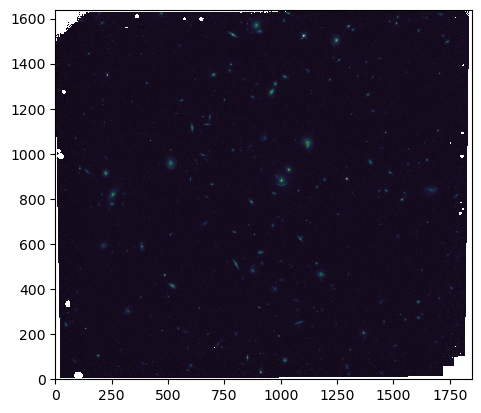

In [5]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background Estimation

In [6]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


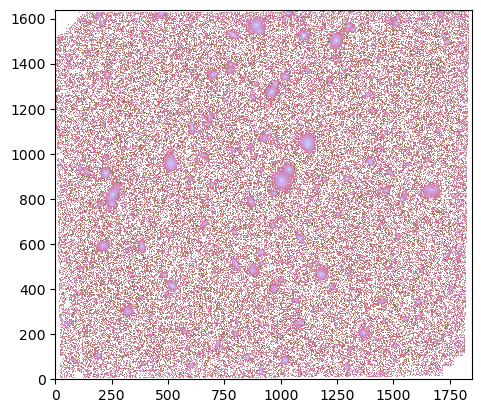

In [7]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry

In [8]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.25551219532307734, 0.012066100362562024)

In [9]:
bkg_subtracted_data = data - bkg.background

In [10]:
threshold = 5 * bkg.background_rms

In [11]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [12]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [13]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (1640, 1849)
nlabels: 524
labels: [  1   2   3   4   5 ... 520 521 522 523 524]


In [14]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 524
labels: [  1   2   3   4   5 ... 520 521 522 523 524]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [15]:
set_x_lim1, set_x_lim2 = 500, 1500
set_y_lim1, set_y_lim2 = 600, 1350

C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\1367821160.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


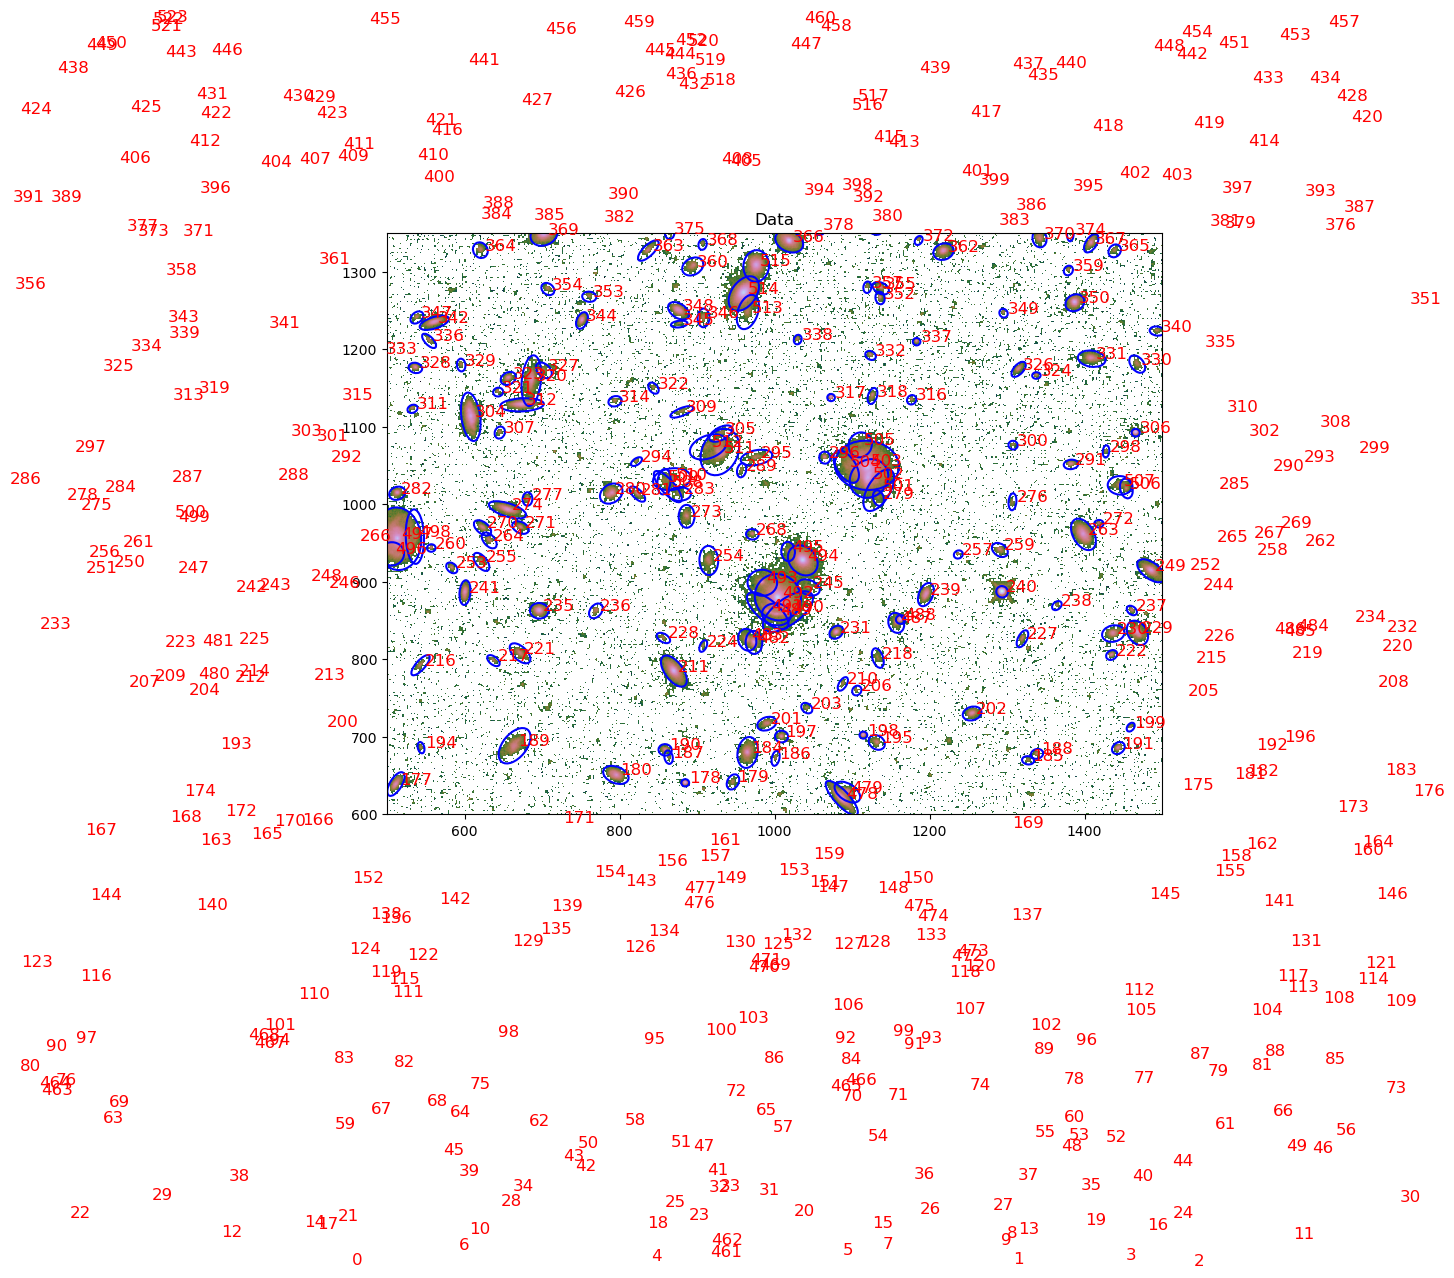

In [16]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\4184686873.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


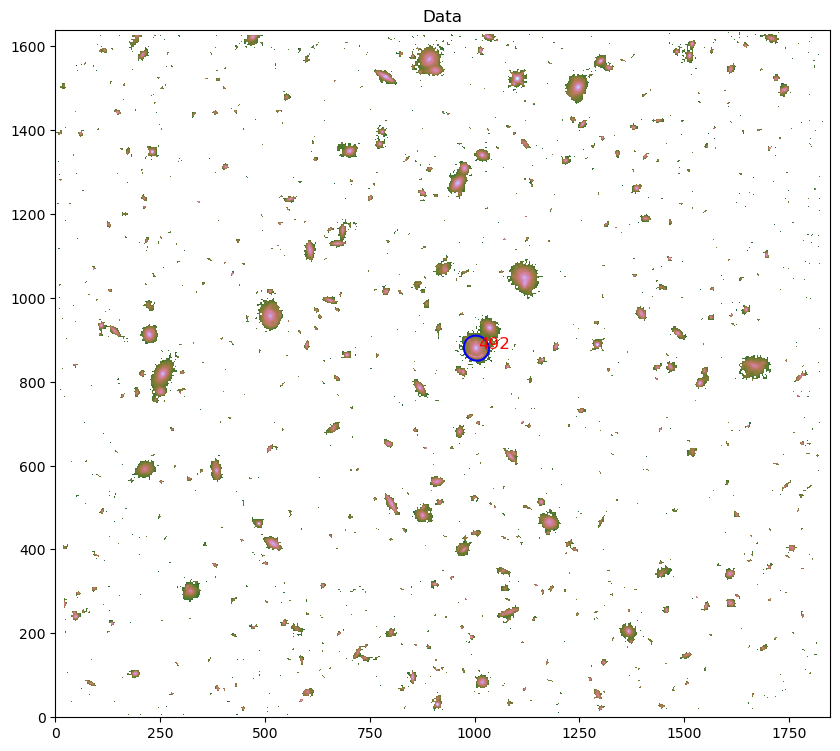

In [17]:
# object id of your central deflector/lens
id_central = 492

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

# ax1.set_xlim(set_x_lim1, set_x_lim2)
# ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Close Galaxies, Distance, Flux

In [18]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [19]:
# All close galaxies
x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print("Number of All Close galaxies:", len(close_galaxies_all))

Number of All Close galaxies: 52


In [20]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print("Number of Close galaxies excluding dim sources:", len(close_galaxies_1))

Number of Close galaxies excluding dim sources: 42


In [21]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [22]:
n_sys = 5  # number of galaxies detected inside your lensing system

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_all_sys_removed = df_all_sorted.iloc[n_sys:]

# first 10 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
245         41.513453          3.321076   14.979994    0.637094
494         57.396017          4.591681  367.096557    0.795915
495         60.368131          4.829450   11.653550    0.698637
482         65.959762          5.276781   51.045589    0.724552
483         67.638345          5.411068   28.429093    0.797171
268         87.611630          7.008930    6.884013    0.827438
231         87.890268          7.031221   31.715868    0.763029
254        100.986307          8.078905   22.246797    0.640860
224        115.084141          9.206731    2.678914    0.529612
210        139.786441         11.182915    3.236779    0.496465
203        147.888086         11.831047    3.117071    0.736577
218        150.957942         12.076635    6.830461    0.521050
487        156.251398         12.500112   16.429314    0.754942
228        156.744578         12.539566    3.412065    0.559033
273        157.381474         12.590518 

In [23]:
# number of galaxies detected inside your lensing system

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.iloc[n_sys:]

# first 10 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
245         41.513453          3.321076   14.979994    0.637094
494         57.396017          4.591681  367.096557    0.795915
495         60.368131          4.829450   11.653550    0.698637
482         65.959762          5.276781   51.045589    0.724552
483         67.638345          5.411068   28.429093    0.797171
268         87.611630          7.008930    6.884013    0.827438
231         87.890268          7.031221   31.715868    0.763029
254        100.986307          8.078905   22.246797    0.640860
218        150.957942         12.076635    6.830461    0.521050
487        156.251398         12.500112   16.429314    0.754942
273        157.381474         12.590518   17.925073    0.693093
488        160.956856         12.876549   48.383008    0.909309
201        163.786753         13.102940   14.706347    0.651256
211        164.601358         13.168109  177.197801    0.496080
197        179.780757         14.382461 

### $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation

C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\78754443.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\78754443.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\78754443.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
C:\Users\HTCM\AppData\Local\Temp\ipykernel_11068\78754443.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 12.500111844774075
R 20: 15.203554119692674
Sigma 10: 0.02037146816337099
Sigma 20: 0.027541644876136265

FOR All SOURCES
R 10: 11.18291529723642
R 20: 13.628767975592424
Sigma 10: 0.025453063233903294
Sigma 20: 0.03427416847357062


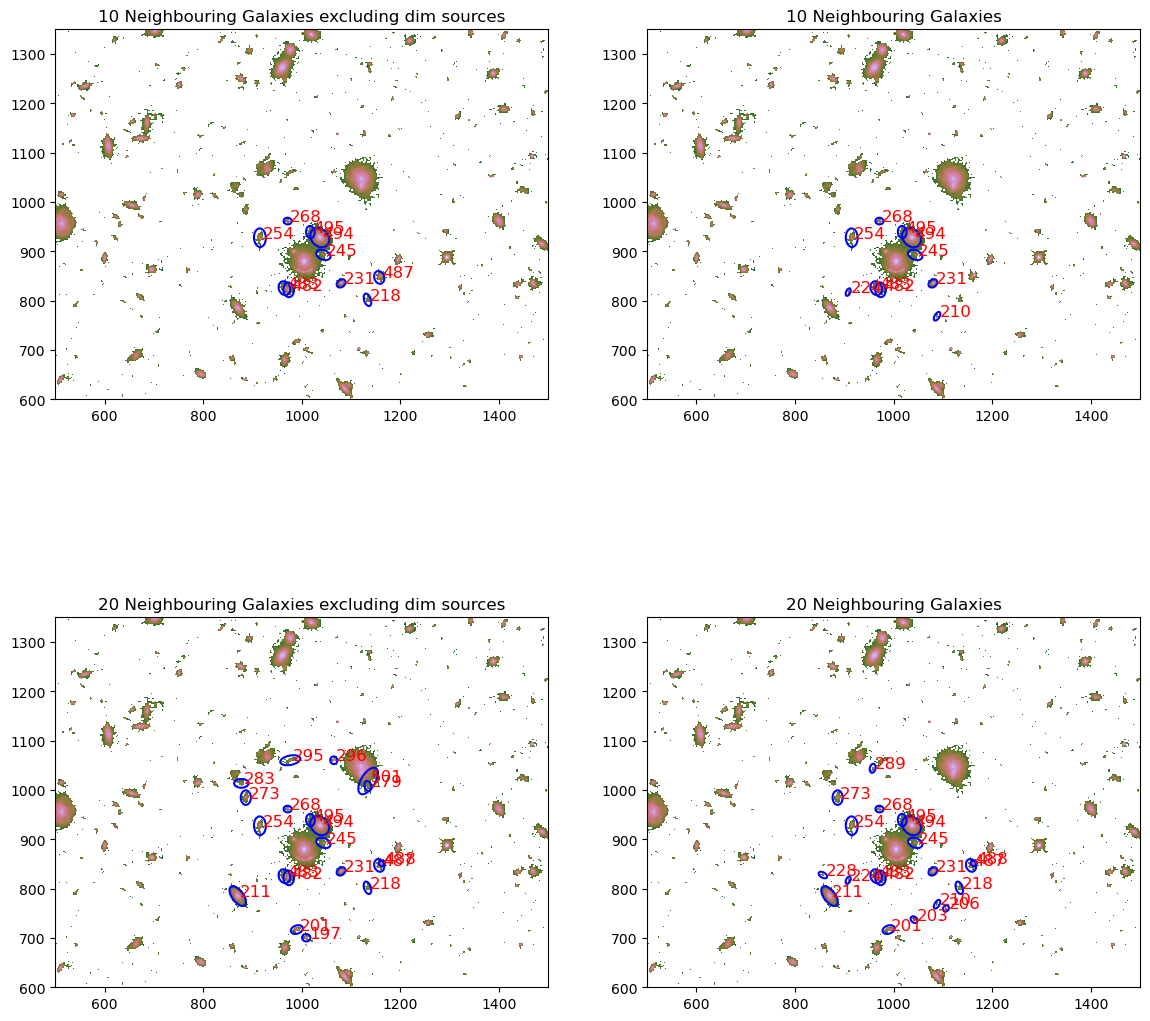

In [24]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

## Saving the results in YAML file

In [25]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1537+1443_point_estimates.yml"

# Variables to include in the YAML file
environment_params = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_params.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [26]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 16
{'Sigma_10': 0.025453063233903294, 'Sigma_10_flux_selected': 0.02037146816337099, 'Sigma_20': 0.03427416847357062, 'Sigma_20_flux_selected': 0.027541644876136265, 'center_x_light': [-0.06781251377880426, 0.0006395967275077824, 0.0006484258640180596], 'center_x_mass': [-0.07318949617444911, 0.004833828416083916, 0.0054359481713791985], 'center_y_light': [-0.34257704679845125, 0.0006285376533772813, 0.0006334874514735134], 'center_y_mass': [0.15602440854776023, 0.03414937756886219, 0.03235488979065686], 'gamma': [2.1623734796583003, 0.04945105813986794, 0.0441443521986713], 'gamma_shear': [-0.11738541641751771, 0.18322845469496837, 0.24285420449977058], 'phi_light': [1.3415615165872163, 0.017267608609442764, 0.017388356699623575], 'phi_mass': [1.4191625976970073, 0.025588993660968784, 0.02681699888260436], 'phi_shear': [0.027002839229764174, 0.014649912686141117, 0.0139252291716471], 'q_light': [0.8808601605474355, 0.0038218519013191177, 0.0039609497382688